In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from pandas_ml_utils import pd

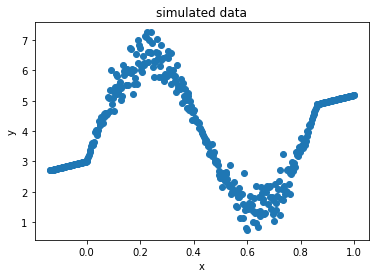

In [2]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0, 0.15 * np.abs(y1), n), np.zeros(60)))
    x = np.concatenate((np.linspace(-3, 0, 60), np.linspace(0, 3 * 2 * np.pi, n),np.linspace( 3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)))
    y2 = 0.1*x+1
    y = (y1+y2) + 2
    return x / x[-1], y


## use custom function to simulate some data
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

<AxesSubplot:>

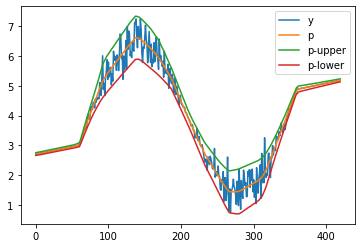

In [5]:
df = pd.DataFrame(np.array(create_sine_data(300)).T, columns=["x", "y"])

with df.model('/tmp/probabilistic.model') as m:
    from pandas_ml_utils import FeaturesLabels, FittingParameter, FittableModel
    from pandas_ml_utils_torch import PytorchNN, PytorchModelProvider, lossfunction
    from pandas_ml_common.sampling.splitter import dummy_splitter
    from torch.optim import Adam, SGD, Adadelta, Adamax, LBFGS
    from torch import nn
    import torch as t

    #t.manual_seed(32)

    class Net(PytorchNN):

        def __init__(self):
            super().__init__()
            self.l = nn.Sequential(
                nn.Linear(1, 200),
                nn.ReLU(),
                nn.Linear(200, 200),
                nn.ReLU(),
                nn.Linear(200, 200),
                nn.ReLU(),
                nn.Linear(200, 2),
            )

        def forward_training(self, x):
            return self.l(x)

        def forward_predict(self, x):
            x = self.l(x)
            # for sigma we use t.exp(sigma) to ensure non negative values, therefore we need to convert the value first
            x[:, 1] = t.exp(x[:, 1])
            return x

    fit = m.fit(
        FittableModel(
            PytorchModelProvider(
                Net,
                lossfunction.HeteroscedasticityLoss,
                Adam,
            ),
            FeaturesLabels(features=["x"], labels=["y"])
        ),
        FittingParameter(epochs=2000, splitter=dummy_splitter)
    )

fit.training_summary.df.ML[[
    "label",
    lambda df: df["prediction"].apply(lambda r: r[0][0], axis=1).rename("p"),
    lambda df: df["prediction"].apply(lambda r: r[0][0] + 2 * r[0][1], axis=1).rename("p-upper"),
    lambda df: df["prediction"].apply(lambda r: r[0][0] - 2 * r[0][1], axis=1).rename("p-lower"),
]].plot()